In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import math
from time import time
import pickle
import pandas as pd
import numpy as np
from time import time

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
import sys
sys.path.append('../src')
from preprocessing import *
from utils import *
from plotting import *

In [4]:
# Varía ciertos hiperparámetros e imprime los resultados más relevantes
def hyper_sim(df,num_val,n_hid_layers,n_neur,alpha,features,over_dict=None,under_dict=None):
    errs_acc = []
    errs_f1 = []
    rec_ban = []
    loss = []
    for i in range(num_val):
        df_train, df_test = split_series_byID(0.75, df)
        df_train, df_test = norm_train_test(df_train,df_test,features_to_norm=features)
        xtrain, ytrain = df_train[features].values, df_train['class'].values
        if over_dict and under_dict:
            over_sampling = SMOTE(sampling_strategy=over_dict)
            under_sampling = RandomUnderSampler(sampling_strategy=under_dict)
            xtrain, ytrain = over_sampling.fit_resample(xtrain, ytrain)
            xtrain, ytrain = under_sampling.fit_resample(xtrain, ytrain)
        xtest, ytest = df_test[features].values, df_test['class'].values
        
        tup = []
        for i in range(n_hid_layers):
            tup.append(n_neur)
        tup = tuple(tup)

        clf_nn = MLPClassifier(
                hidden_layer_sizes=tup,
                max_iter=2000,
                early_stopping=True,
                shuffle=True,
                alpha=alpha,
                learning_rate='adaptive'
            )

        clf_nn.fit(xtrain, ytrain)
        ypred = clf_nn.predict(xtest)
        errs_acc.append(accuracy_score(ytest,ypred))
        errs_f1.append(f1_score(ytest,ypred,average='weighted'))
        rec_ban.append(np.sum(np.logical_and(ytest=='banana',ypred=='banana'))/np.sum(ytest=='banana'))
        loss.append(clf_nn.loss_)

    errs_acc = np.array(errs_acc)
    errs_f1 = np.array(errs_f1)
    rec_ban = np.array(rec_ban)
    loss = np.array(loss)
    print('Train loss:',np.mean(loss),'+-',np.std(loss))
    print('Accuracy:',np.mean(errs_acc),'+-',np.std(errs_acc))
    print('F1-score:',np.mean(errs_f1),'+-',np.std(errs_f1))
    print('Recall bananas:',np.mean(rec_ban),'+-',np.std(rec_ban))

# Modified dataset

In [5]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)
df_db.head()

,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity,id,date,class,t0,dt,t0_delay,dt_delay
0,12.490250,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528,0,07-04-15,background,13.49,1.64,0.0,0.0
1,12.490528,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,0,07-04-15,background,13.49,1.64,0.0,0.0
2,12.490806,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,0,07-04-15,background,13.49,1.64,0.0,0.0
3,12.491084,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,0,07-04-15,background,13.49,1.64,0.0,0.0
4,12.491373,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,0,07-04-15,background,13.49,1.64,0.0,0.0


In [8]:
# Validación simple de n_iter ejecuciones para decidir la constante de aprendizaje, el número de capas ocultas y
# el número de neuronas
list_alpha = [0.01,0.001]
list_hid_layers = range(2,5)
list_neur = [2,4,8]
n_iter = 5
for alpha in list_alpha:
    print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>')
    print('Alpha:',alpha)
    for n_hid_layers in list_hid_layers:
        print('##############################################')
        print('\t Hidden layers:',n_hid_layers)
        for n_neur in list_neur:
            print('==============================================')
            print('\t \t Neurons per layer:',n_neur)
            hyper_sim(df_db,n_iter,n_hid_layers,n_neur,alpha,features)
            print('==============================================')

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>
Alpha: 0.01
##############################################
	 Hidden layers: 2
	 	 Neurons per layer: 2
Train loss: 0.3916246646420336 +- 0.0350024483286658
Accuracy: 0.8284198332623605 +- 0.029885100502695
F1-score: 0.7866374098832829 +- 0.04893277144103149
Recall bananas: 0.11498074622482941 +- 0.1422750013256773
	 	 Neurons per layer: 4
Train loss: 0.28711141493179976 +- 0.02455610698895882
Accuracy: 0.8344744535174758 +- 0.018372318244468833
F1-score: 0.8231780894289331 +- 0.02653388965763423
Recall bananas: 0.2780092596991882 +- 0.12186590199593533
	 	 Neurons per layer: 8
Train loss: 0.18114278402911027 +- 0.016025121020812518
Accuracy: 0.7927781405115872 +- 0.04760446139721019
F1-score: 0.7933794153146965 +- 0.042888183236859126
Recall bananas: 0.3101826247058851 +- 0.09964255670467992
##############################################
	 Hidden layers: 3
	 	 Neurons per layer: 2
Train loss: 0.4308768729110213 +- 0.15069859915456565
Accur

Elegimos 3 capas ocultas, 4 neuronas por capa y un alpha 0.01

Ahora probamos a hacer bagging con 20 estimadores.

In [11]:
n_iter = 5
layers = (4,4,4)
alpha = 0.01

errs_acc = []
errs_f1 = []
rec_ban = []
for i in range(10):
    df_train, df_test = split_series_byID(0.75, df_db)
    df_train, df_test = norm_train_test(df_train,df_test,features_to_norm=features)
    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    clf_nn = MLPClassifier(
        hidden_layer_sizes=layers,
        max_iter=2000,
        early_stopping=True,
        shuffle=True,
        alpha=alpha,
        learning_rate='adaptive'
        )

    bag = BaggingClassifier(base_estimator=clf_nn,n_estimators=20,n_jobs=3)

    bag.fit(xtrain, ytrain)
    ypred = bag.predict(xtest)
    errs_acc.append(accuracy_score(ytest,ypred))
    errs_f1.append(f1_score(ytest,ypred,average='weighted'))
    rec_ban.append(np.sum(np.logical_and(ytest=='banana',ypred=='banana'))/np.sum(ytest=='banana'))

errs_acc = np.array(errs_acc)
errs_f1 = np.array(errs_f1)
rec_ban = np.array(rec_ban)
print('Accuracy:',np.mean(errs_acc),'+-',np.std(errs_acc))
print('F1-score:',np.mean(errs_f1),'+-',np.std(errs_f1))
print('Recall bananas:',np.mean(rec_ban),'+-',np.std(rec_ban))

Accuracy: 0.8439662843338537 +- 0.05739720482516567
F1-score: 0.8296699177597638 +- 0.0655385850230548
Recall bananas: 0.25925942717612216 +- 0.08496264509329657


# Windows

In [6]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

win_df = pd.read_pickle('../datasets/preprocessed/window120_dataset.pkl')

In [6]:
# Validación simple de 10 ejecuciones para decidir la constante de aprendizaje, el número de capas ocultas y
# el número de neuronas
for alpha in [0.01,0.001]:
    print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>')
    print('Alpha:',alpha)
    for n_hid_layers in range(2,5):
        print('##############################################')
        print('\t Hidden layers:',n_hid_layers)
        for n_neur in [2,4,8]:
            print('==============================================')
            print('\t \t Neurons per layer:',n_neur)
            hyper_sim(win_df,10,n_hid_layers,n_neur,alpha,features)
            print('==============================================')

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>
Alpha: 0.01
##############################################
	 Hidden layers: 2
	 	 Neurons per layer: 2
Train loss: 0.3369292638080534 +- 0.01898777366073932
Accuracy: 0.8614995653739118 +- 0.013802793278683207
F1-score: 0.8477053916986094 +- 0.02269791360032949
Recall bananas: 0.27286655706901736 +- 0.13537520341231715
	 	 Neurons per layer: 4
Train loss: 0.25103889475688124 +- 0.02103813588063515
Accuracy: 0.8550185358754737 +- 0.01473824536252829
F1-score: 0.8413171659320327 +- 0.011710756562335249
Recall bananas: 0.32072884775245203 +- 0.14954677863898094
	 	 Neurons per layer: 8
Train loss: 0.15008099671145567 +- 0.006708852855497587
Accuracy: 0.8055775903424107 +- 0.021140383711052996
F1-score: 0.8088981076874298 +- 0.022004382367473173
Recall bananas: 0.33186436122857177 +- 0.06900749905851701
##############################################
	 Hidden layers: 3
	 	 Neurons per layer: 2
Train loss: 0.36515380967254024 +- 0.01634684196598

In [9]:
hyper_sim(win_df,10,3,4,0.01,features)

Train loss: 0.24018066820164438 +- 0.023418848195325886
Accuracy: 0.8637574268900602 +- 0.02871614724926834
F1-score: 0.8553617572371873 +- 0.031009063536019333
Recall bananas: 0.39207973741325436 +- 0.092974568441552


Al igual que antes, elegimos 3 capas ocultas, 4 neuronas por capa y un alpha 0.01. Aunque hay mejores resultados, tienen demasiada desviación típica como para ser fiables.

Ahora probamos a hacer bagging con 20 estimadores.

In [7]:
errs_acc = []
errs_f1 = []
rec_ban = []
for i in range(10):
    df_train, df_test = split_series_byID(0.75, win_df)
    df_train, df_test = norm_train_test(df_train,df_test,features_to_norm=features)
    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    clf_nn = MLPClassifier(
        hidden_layer_sizes=(4,4,4),
        max_iter=2000,
        early_stopping=True,
        shuffle=True,
        alpha=0.01,
        learning_rate='adaptive'
        )

    bag = BaggingClassifier(base_estimator=clf_nn,n_estimators=20,n_jobs=3)

    bag.fit(xtrain, ytrain)
    ypred = bag.predict(xtest)
    errs_acc.append(accuracy_score(ytest,ypred))
    errs_f1.append(f1_score(ytest,ypred,average='weighted'))
    rec_ban.append(np.sum(np.logical_and(ytest=='banana',ypred=='banana'))/np.sum(ytest=='banana'))

errs_acc = np.array(errs_acc)
errs_f1 = np.array(errs_f1)
rec_ban = np.array(rec_ban)
print('Accuracy:',np.mean(errs_acc),'+-',np.std(errs_acc))
print('F1-score:',np.mean(errs_f1),'+-',np.std(errs_f1))
print('Recall bananas:',np.mean(rec_ban),'+-',np.std(rec_ban))

TEST SET PROPORTIONS:
	Real background percentage: 0.7869345926926833
	Real banana percentage: 0.09259234484327131
	Real wine percentage: 0.12047306246404538
------------------------------------------
Accuracy: 0.895500822775496
Recall on background: 0.9620033661447442
Recall on banana: 0.6426335307999808
Recall on wine: 0.65545067555062
F1-score: 0.8939343748402855
TEST SET PROPORTIONS:
	Real background percentage: 0.7070396595801938
	Real banana percentage: 0.09927509418729817
	Real wine percentage: 0.19368524623250807
------------------------------------------
Accuracy: 0.818205900161464
Recall on background: 0.9609517635934368
Recall on banana: 0.16950444726810673
Recall on wine: 0.6296159607494084
F1-score: 0.792719333808237
TEST SET PROPORTIONS:
	Real background percentage: 0.7244155558003745
	Real banana percentage: 0.12466674011237193
	Real wine percentage: 0.1509177040872535
------------------------------------------
Accuracy: 0.8511093973779883
Recall on background: 0.9761904

# Smote

In [24]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

win_df = pd.read_pickle('../datasets/preprocessed/window120_dataset.pkl')

over_dict = {'banana': 175000, 'wine': 175000}
under_dict = {'background': 500000}

In [26]:
# Validación simple de 10 ejecuciones para decidir la constante de aprendizaje, el número de capas ocultas y
# el número de neuronas
for alpha in [0.01,0.001]:
    print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>')
    print('Alpha:',alpha)
    for n_hid_layers in range(2,5):
        print('##############################################')
        print('\t Hidden layers:',n_hid_layers)
        for n_neur in [2,4,8]:
            print('==============================================')
            print('\t \t Neurons per layer:',n_neur)
            hyper_sim(win_df,10,n_hid_layers,n_neur,alpha,features,over_dict=over_dict,under_dict=under_dict)
            print('==============================================')

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>
Alpha: 0.01
##############################################
	 Hidden layers: 2
	 	 Neurons per layer: 2
Train loss: 0.5488535924240698 +- 0.21046260621523777
Accuracy: 0.8271824672424748 +- 0.0444991777822927
F1-score: 0.8038085542601353 +- 0.07510036911176725
Recall bananas: 0.3496213514627672 +- 0.2131246020306895
	 	 Neurons per layer: 4
Train loss: 0.3185648758281586 +- 0.022205933514169364
Accuracy: 0.8121943421500776 +- 0.029241303750929024
F1-score: 0.819819580056623 +- 0.02658073479470294
Recall bananas: 0.4106811750623657 +- 0.09157163857353492
	 	 Neurons per layer: 8
Train loss: 0.1440066255811115 +- 0.016734622110107483
Accuracy: 0.7561186546743115 +- 0.01949760318613811
F1-score: 0.7584008535355601 +- 0.006767609476800042
Recall bananas: 0.34648036125721304 +- 0.13061643798541048
##############################################
	 Hidden layers: 3
	 	 Neurons per layer: 2
Train loss: 0.4749120460553636 +- 0.07229212674257438
Accur

In [27]:
# Mejor opción
hyper_sim(win_df,10,3,4,0.01,features,over_dict=over_dict,under_dict=under_dict)

Train loss: 0.3174721772856896 +- 0.027246001164953758
Accuracy: 0.8224637333552776 +- 0.034269443248349775
F1-score: 0.8301484949130975 +- 0.03307461316084157
Recall bananas: 0.47073848708416133 +- 0.1181386744211724


In [29]:
errs_acc = []
errs_f1 = []
rec_ban = []
for i in range(10):
    df_train, df_test = split_series_byID(0.75, win_df)
    df_train, df_test = norm_train_test(df_train,df_test,features_to_norm=features)
    xtrain, ytrain = df_train[features].values, df_train['class'].values
    over_sampling = SMOTE(sampling_strategy=over_dict)
    under_sampling = RandomUnderSampler(sampling_strategy=under_dict)
    xtrain, ytrain = over_sampling.fit_resample(xtrain, ytrain)
    xtrain, ytrain = under_sampling.fit_resample(xtrain, ytrain)
    xtest, ytest = df_test[features].values, df_test['class'].values

    clf_nn = MLPClassifier(
        hidden_layer_sizes=(4,4,4),
        max_iter=2000,
        early_stopping=True,
        shuffle=True,
        alpha=0.01,
        learning_rate='adaptive'
        )

    bag = BaggingClassifier(base_estimator=clf_nn,n_estimators=20,n_jobs=3)

    bag.fit(xtrain, ytrain)
    ypred = bag.predict(xtest)
    errs_acc.append(accuracy_score(ytest,ypred))
    errs_f1.append(f1_score(ytest,ypred,average='weighted'))
    rec_ban.append(np.sum(np.logical_and(ytest=='banana',ypred=='banana'))/np.sum(ytest=='banana'))

errs_acc = np.array(errs_acc)
errs_f1 = np.array(errs_f1)
rec_ban = np.array(rec_ban)
print('Accuracy:',np.mean(errs_acc),'+-',np.std(errs_acc))
print('F1-score:',np.mean(errs_f1),'+-',np.std(errs_f1))
print('Recall bananas:',np.mean(rec_ban),'+-',np.std(rec_ban))

TEST SET PROPORTIONS:
	Real background percentage: 0.7261303338023632
	Real banana percentage: 0.1202765016020479
	Real wine percentage: 0.15359316459558886
------------------------------------------
Accuracy: 0.8245588010917659
Recall on background: 0.8768101138744754
Recall on banana: 0.6473801050072236
Recall on wine: 0.716280353200883
F1-score: 0.8326610440983933
TEST SET PROPORTIONS:
	Real background percentage: 0.7762145091408189
	Real banana percentage: 0.10652743536457862
	Real wine percentage: 0.11725805549460241
------------------------------------------
Accuracy: 0.873000916448311
Recall on background: 0.9137284029998836
Recall on banana: 0.4742921765822529
Recall on wine: 0.9656184640223094
F1-score: 0.8733368939127423
TEST SET PROPORTIONS:
	Real background percentage: 0.7684564355994835
	Real banana percentage: 0.11653087574017186
	Real wine percentage: 0.1150126886603446
------------------------------------------
Accuracy: 0.862664173456213
Recall on background: 0.9539231

# Prueba de Windows vs Clean

Creamos un ensemble de redes neuronales con Bagging y comprobamos (para el mismo conjunto train y test) cómo mejora un elemento de clase banana

In [8]:
layers = (4,4,4)
alpha = 0.01

df_train, df_test = split_series_byID(0.75, win_df)
df_train, df_test = norm_train_test(df_train,df_test,features_to_norm=features)
xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values

clf_nn = MLPClassifier(
    hidden_layer_sizes=layers,
    max_iter=2000,
    early_stopping=True,
    shuffle=True,
    alpha=alpha,
    learning_rate='adaptive'
    )

bag = BaggingClassifier(base_estimator=clf_nn,n_estimators=20,n_jobs=3)
bag.fit(xtrain, ytrain)
ypred = bag.predict(xtest)

TEST SET PROPORTIONS:
	Real background percentage: 0.7549277987046302
	Real banana percentage: 0.12431865920023855
	Real wine percentage: 0.12075354209513119
------------------------------------------
Accuracy: 0.8241910516876203
Recall on background: 0.9360115244313297
Recall on banana: 0.346031746031746
Recall on wine: 0.6173875149798453
F1-score: 0.8114019052904452


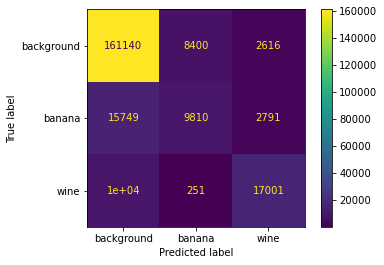

In [16]:
# Con windows
metric_report(ytest,ypred,plot_conf_mtx=True,clf=bag,X=xtest)

In [13]:
over_dict = {'banana': 175000, 'wine': 175000}
under_dict = {'background': 500000}

over_sampling = SMOTE(sampling_strategy=over_dict)
under_sampling = RandomUnderSampler(sampling_strategy=under_dict)

xtrain_smote, ytrain_smote = over_sampling.fit_resample(xtrain, ytrain)
xtrain_smote, ytrain_smote = under_sampling.fit_resample(xtrain_smote, ytrain_smote)

bag_smote = BaggingClassifier(base_estimator=clf_nn,n_estimators=20,n_jobs=3)

bag_smote.fit(xtrain_smote, ytrain_smote)
ypred_smote = bag_smote.predict(xtest)

TEST SET PROPORTIONS:
	Real background percentage: 0.7549277987046302
	Real banana percentage: 0.12431865920023855
	Real wine percentage: 0.12075354209513119
------------------------------------------
Accuracy: 0.7835452085790837
Recall on background: 0.8635830293454774
Recall on banana: 0.43950617283950616
Recall on wine: 0.6373606420452482
F1-score: 0.7885564080225496


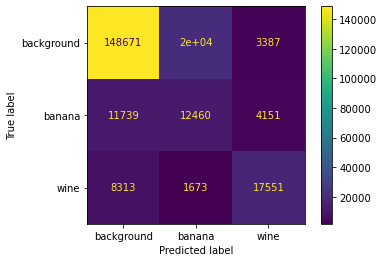

In [15]:
# Con smote
metric_report(ytest,ypred_smote,plot_conf_mtx=True,clf=bag_smote,X=xtest)

In [17]:
# Ids de los elementos del test (para poder escoger una banana del conjunto de test)
set(df_test["id"])

{1,
 3,
 5,
 6,
 7,
 10,
 12,
 21,
 23,
 29,
 30,
 34,
 36,
 40,
 42,
 51,
 52,
 58,
 65,
 77,
 79,
 86,
 89,
 93,
 96}

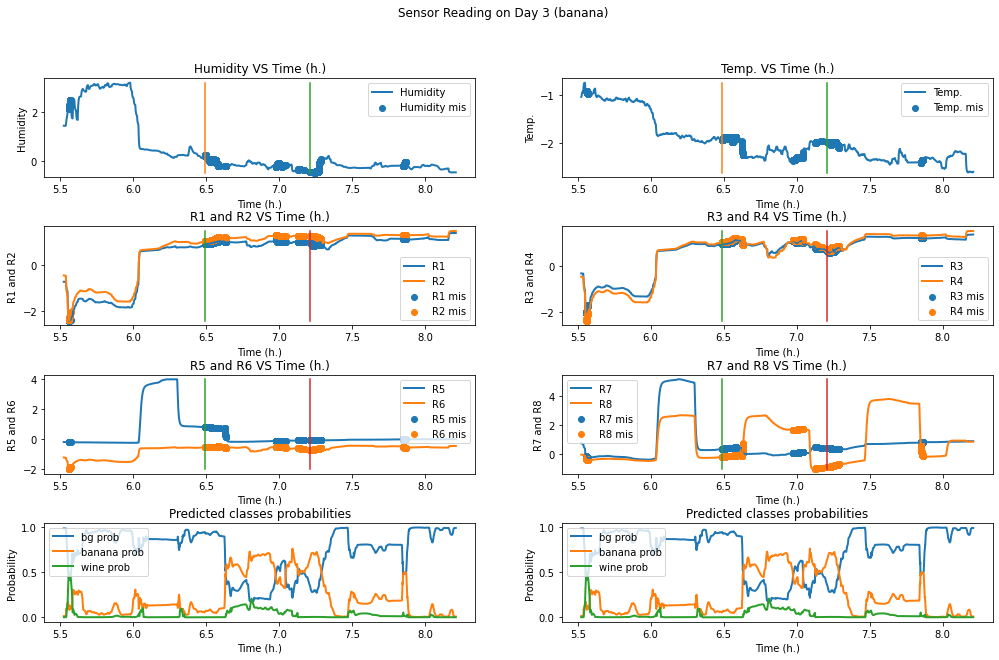

In [47]:
# Predicción del elemento 3 (bananas) con windows
probs_mtx = bag.predict_proba(xtest)
plot_misclassified_byID(df_test, 3, ytest, ypred, probs_mtx=probs_mtx)

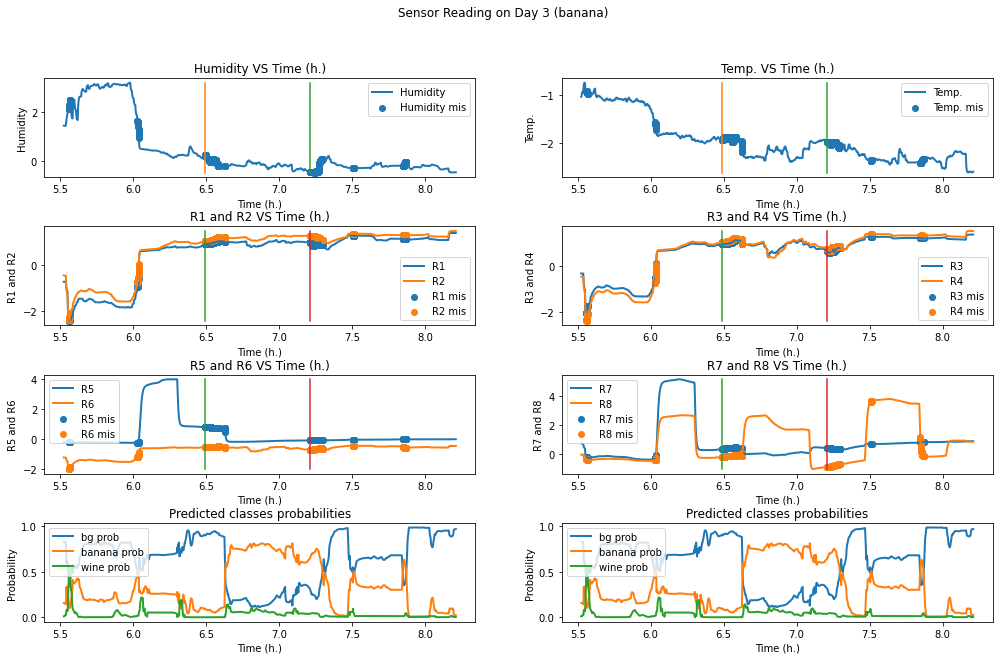

In [48]:
# Predicción del elemento 3 (bananas) con smote
probs_mtx_smote = bag_smote.predict_proba(xtest)
plot_misclassified_byID(df_test, 3, ytest, ypred_smote, probs_mtx=probs_mtx_smote)